# EPRV 6: Sun-as-a-Star Splinter Part I

## Tutorial: Download HARPS-N solar data from DACE

This tutorial shows how to download HARPS-N solar data using the DACE Python API. To install the DACE API:

`pip install dace_query`

Let's start! First, import some needed packages.

In [1]:
from   astropy.io          import fits
from   astropy.time        import Time
from   dace_query.sun      import Sun
from   glob                import glob
import matplotlib.cm       as     cmx
from   matplotlib.colors   import LinearSegmentedColormap, Normalize
import matplotlib.pyplot   as     plt
import numpy               as     np
import os
import tarfile

Specify and create the output directory.

In [2]:
output_directory = 'sun_harpn_ccf/'
os.makedirs(output_directory, exist_ok=True)

Create some filters, query the solar database and download the DRS output files (in this case CCF).

Tip: If you don't know the filter keywords by heart, make a query based on the dates only and then list all the dictionary keywords from the query output.

In [3]:
# Filter: Barycentric Julian Date (BJD)
obj_date_bjd_min = Time('2018-07-01T00:00:00').jd-2400000
obj_date_bjd_max = Time('2018-07-01T23:59:59').jd-2400000

# Filter: Quality flag
spectro_analysis_qualflag_min = 0.95
spectro_analysis_qualflag_max = 1.00

# Filter dictionary
filters = {
'obj_date_bjd'             : {'min': obj_date_bjd_min             , 'max': obj_date_bjd_max             },
'spectro_analysis_qualflag': {'min': spectro_analysis_qualflag_min, 'max': spectro_analysis_qualflag_max},
}

# Query (optional: only to inspect the output before downloading it)
sun_query = Sun.query_database(filters=filters, sort={'obj_date_bjd': 'asc'})

# Download CCF files
Sun.download('ccf', filters=filters, output_directory=output_directory, output_filename='temp.tar', compressed=False)

# Unzip
tar = tarfile.open(output_directory+'temp.tar', 'r:')
tar.extractall(output_directory)
tar.close()

# Delete temporary file
os.remove(output_directory+'temp.tar')

2025-06-27 13:52:27,931 - INFO - Downloading file on location : sun_harpn_ccf/temp.tar


 Download : 6 MB

2025-06-27 13:52:28,474 - INFO - File downloaded on location : sun_harpn_ccf/temp.tar


 Download : 11 MB
Download done


Next, loop the downloaded FITS files and extract whatever data or header variable your analysis requires. Here, we extract the CCFs and RVs.

In [4]:
# Files
files = sorted(glob(output_directory+'**/*.fits', recursive=True))
Nfile = len(files)

# Get CCF velocity grid from first file
hdul     = fits.open(files[0])
Ngrid    = hdul[1].data.shape[1]
grid_min = hdul[0].header['HIERARCH TNG RV START']
grid_del = hdul[0].header['HIERARCH TNG RV STEP']
grid_val = grid_min+grid_del*np.arange(Ngrid)

# Empty arrays for CCF variables
ccf_val  = np.empty((Nfile,Ngrid))
ccf_err  = np.empty((Nfile,Ngrid))

# Empty arrays for RV variables
time_val = np.empty(Nfile)
vrad_val = np.empty(Nfile)
vrad_err = np.empty(Nfile)

# Loop files
for i in range(Nfile):

    # Open FITS file
    hdul = fits.open(files[i])

    # Extract CCF variables
    ccf_val[i] = hdul[1].data[-1] # last row contains the order-combined CCF values
    ccf_err[i] = hdul[2].data[-1] # last row contains the order-combined CCF errors

    # Extract RV variables
    header = hdul[0].header
    time_val[i] = header['HIERARCH TNG QC BJD']
    vrad_val[i] = header['HIERARCH TNG QC CCF RV']
    vrad_err[i] = header['HIERARCH TNG QC CCF RV ERROR']

    # Close FITS file
    hdul.close()

Finally, plot the extracted data.

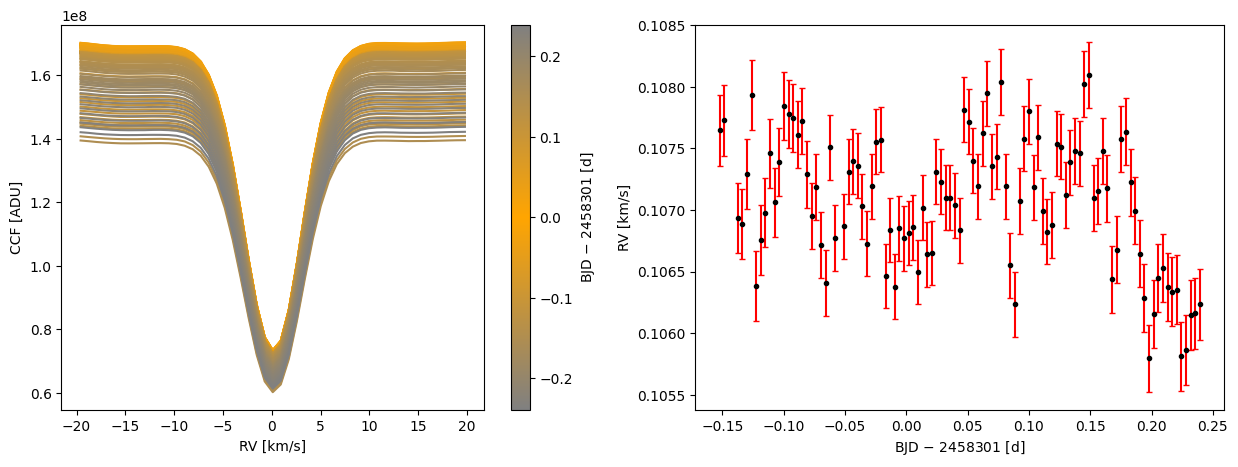

In [5]:
# Normalization
cval   = time_val - int(time_val[-1])
vmax   = np.max([np.abs(np.nanmin(cval)),np.abs(np.nanmax(cval))])
norm   = Normalize(vmin=-vmax, vmax=vmax)

# Color map
colors = ['grey', 'orange', 'grey']
values = [0.0,0.5,1.0]
cmap   = LinearSegmentedColormap.from_list('rg', list(zip(values,colors)), N=256)

# Colors
cmxs   = cmx.ScalarMappable(norm=norm, cmap=cmap)
color  = cmxs.to_rgba(cval)

# Figure
fig, axs = plt.subplots(1,2, figsize=(15,5))

# CCF time series
ax = axs[0]
for i in range(Nfile):
    ax.errorbar(grid_val, ccf_val[i], ccf_err[i], ls='-', color=color[i], ecolor='r')
ax.set_xlabel('RV [km/s]')
ax.set_ylabel('CCF [ADU]')
cb = plt.colorbar(cmxs, ax=ax)
cb.set_label(f'BJD $-$ {int(time_val[-1])} [d]')

# RV time series
ax = axs[1]
ax.errorbar(time_val - int(time_val[-1]), vrad_val, vrad_err, fmt='.', color='k', ecolor='r', capsize=2)
ax.set_xlabel(f'BJD $-$ {int(time_val[-1])} [d]')
ax.set_ylabel('RV [km/s]')

# Show
plt.show()